In [ ]:
# Correr para instalar, en caso de ser necesario
!pip install torch torchvision
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout
from torch_geometric.datasets import Amazon

In [ ]:
# Import dataset from PyTorch Geometric
dataset = Amazon(root=".", name="Computers")

Processing...
Done!


In [ ]:
# Access the first data instance
data = dataset[0]

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=16):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=8) #h=8

In [ ]:
def forward(self, x, edge_index):
    h = F.dropout(x, p=0.1, training=self.training) #p=0.1
    h = self.gat1(h, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.1, training=self.training) #p=0.1
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

GAT.forward = forward

In [ ]:
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01) #weight_decay=0.01

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 20 == 0):
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

GAT.fit = fit

In [ ]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GAT.test = test

In [ ]:
# Fijar la semilla
torch.manual_seed(42)

# Get the total number of nodes
num_nodes = data.num_nodes

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split indices
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

# Create masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[perm[:train_end]] = True
data.val_mask[perm[train_end:val_end]] = True
data.test_mask[perm[val_end:]] = True

In [ ]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

gat.fit(data, epochs=200)

GAT(
  (gat1): GATv2Conv(767, 32, heads=16)
  (gat2): GATv2Conv(512, 10, heads=8)
)
Epoch   0 | Train Loss: 4.679 | Train Acc:  0.06% | Val Loss: 4.69 | Val Acc: 0.00%
Epoch  20 | Train Loss: 1.611 | Train Acc: 62.48% | Val Loss: 1.75 | Val Acc: 60.95%
Epoch  40 | Train Loss: 0.755 | Train Acc: 77.25% | Val Loss: 0.83 | Val Acc: 76.73%
Epoch  60 | Train Loss: 0.481 | Train Acc: 84.44% | Val Loss: 0.51 | Val Acc: 84.65%
Epoch  80 | Train Loss: 0.365 | Train Acc: 87.87% | Val Loss: 0.44 | Val Acc: 87.27%
Epoch 100 | Train Loss: 0.302 | Train Acc: 90.57% | Val Loss: 0.39 | Val Acc: 88.44%
Epoch 120 | Train Loss: 0.258 | Train Acc: 91.66% | Val Loss: 0.38 | Val Acc: 89.09%
Epoch 140 | Train Loss: 0.224 | Train Acc: 92.52% | Val Loss: 0.36 | Val Acc: 89.75%
Epoch 160 | Train Loss: 0.203 | Train Acc: 93.55% | Val Loss: 0.35 | Val Acc: 89.75%
Epoch 180 | Train Loss: 0.171 | Train Acc: 94.45% | Val Loss: 0.35 | Val Acc: 90.40%
Epoch 200 | Train Loss: 0.157 | Train Acc: 94.72% | Val Loss: 0.38 

In [ ]:
# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 90.33%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Asumiendo que tu modelo y datos ya están en el dispositivo correcto
gat.eval()  # Establecer el modelo en modo evaluación

with torch.no_grad():
    logits = gat(data.x, data.edge_index)  # Logits son las salidas del modelo antes de la activación softmax
    predictions = logits.argmax(dim=1)  # Obtener la clase predicha

# Etiquetas reales
true_labels = data.y

# Verificar que estén en la CPU para trabajar con numpy
if predictions.is_cuda:
    predictions = predictions.cpu()
if true_labels.is_cuda:
    true_labels = true_labels.cpu()

predictions = predictions.numpy()
true_labels = true_labels.numpy()

# Calcular la matriz de confusión
conf_mat = confusion_matrix(true_labels, predictions, labels=np.arange(dataset.num_classes))

# Normalizar la matriz de confusión por filas
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

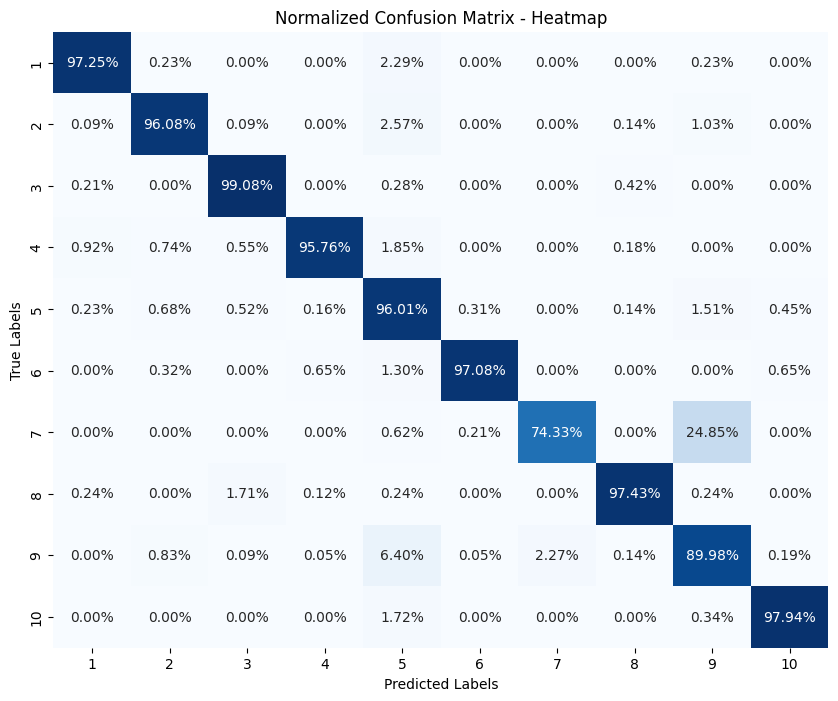

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap='Blues', cbar=False, xticklabels=range(1, dataset.num_classes+1), yticklabels=range(1, dataset.num_classes+1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix - Heatmap')
plt.show()